O modelo ARIMA
==============

Professor: Marcos Cesar Gritti  
Email: cesargritti@gmail.com

Neste módulo vamos aprender sobre:
 1. **Modelo AR - Mínimos Quadrados**;
 2. **Modelo ARMA - Mínimos Quadrados Recursivo**;
 3. **Modelo ARIMA - Biblioteca Scipy**;

Processo ARIMA(1, 0, 0) ~ AR(1) - Mínimos Quadrados
-----------------------------------------------

Começaremos hoje aprendendo a estimar os coeficientes de um modelo Auto-Regressivo para uma Série Termporal sintética descrita pelo equação:

\begin{equation}
    y_k = 0.6 y_{k-1} + \xi_k
\end{equation}

onde $\xi_k \sim N(0, 1)$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

sns.set(
    style="whitegrid",
    rc={"figure.figsize": (14, 8), "lines.linewidth": 2, "figure.dpi": 100},
    font_scale=1.25,
    
)

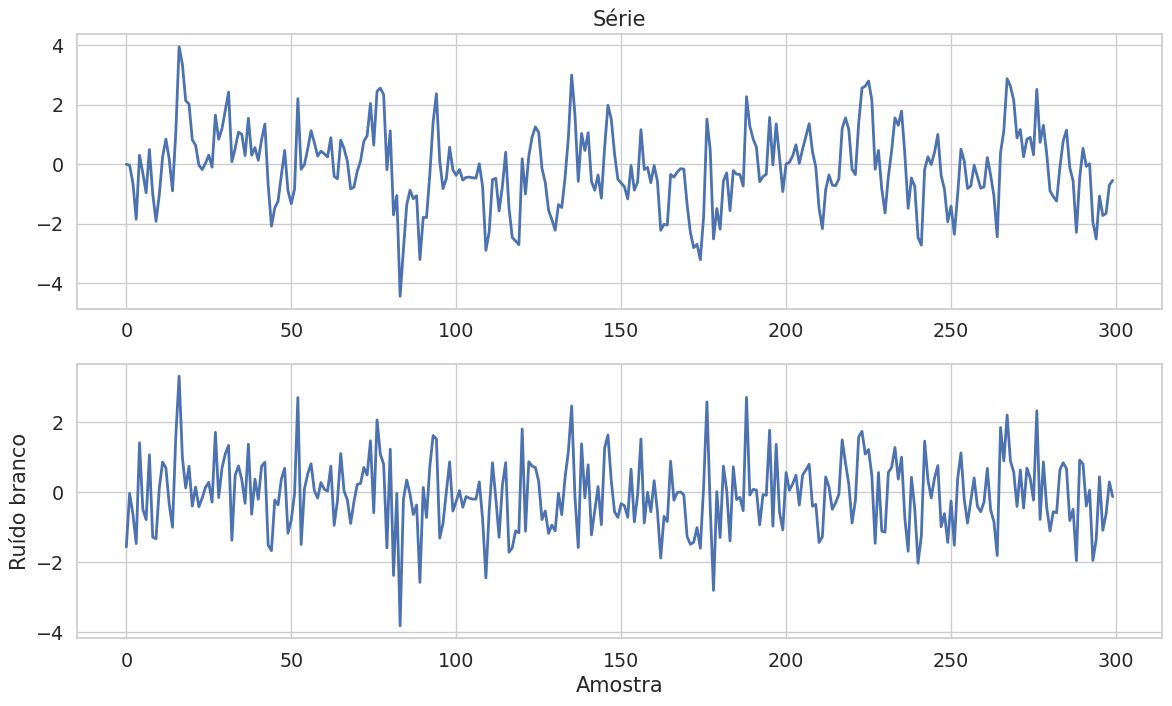

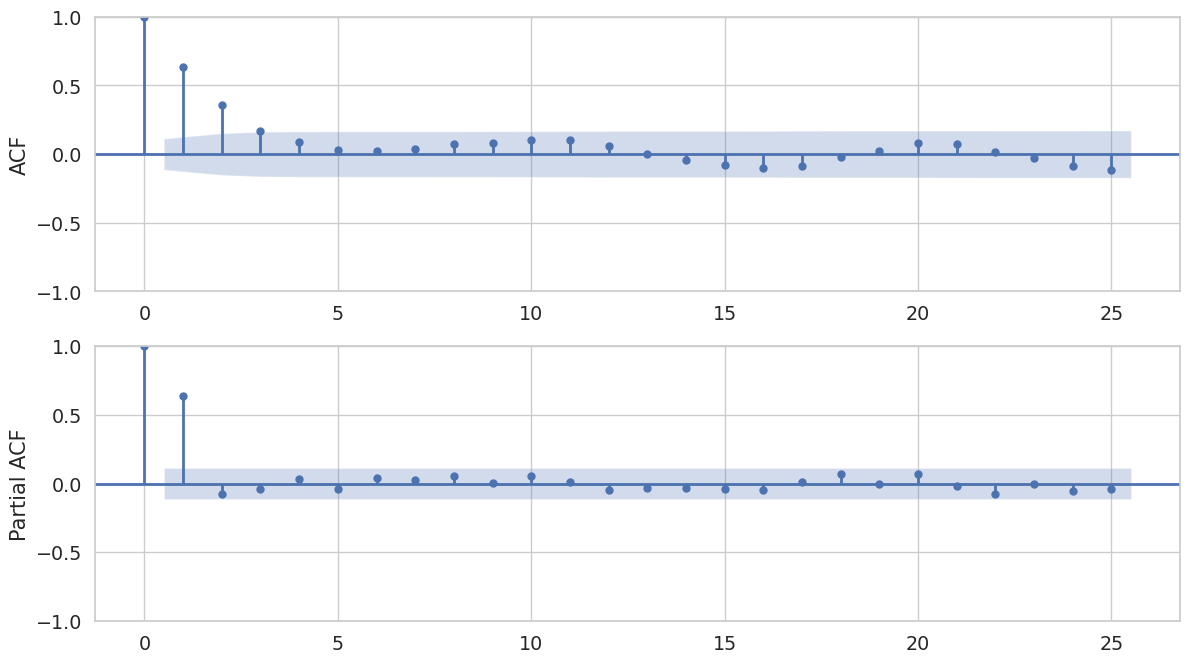

In [6]:
import random

random.seed(50)
np.random.seed(50)

samples = 300

t = np.arange(samples)
y = np.zeros((samples, 1))
e = np.random.randn(samples, 1) # Ruído branco: média 0, desvio padrão 1

for k in range(1, samples):
    y[k] = 0.6 * y[k-1] + e[k]

def plot_ts(t, y, e):
    """Visualização série temporal.
    
    :param t: Vetor tempo
    :param y: Série temporal
    :param e: Ruído sintético
    """
    plt.subplot(211)
    plt.plot(t, y)
    plt.title("Série")
    
    plt.subplot(212)
    plt.plot(t, e)
    plt.ylabel("Ruído branco")
    plt.xlabel("Amostra")
    
def plot_osa(t, y, p, e, r):
    """Visualização da predição 1 passo à frente (OSA, One Step Ahead).
    
    :param t: Vetor tempo
    :param y: Série temporal
    :param p: Predição 1 passo a frente
    :param e: Ruído sintético
    :param r: Resíduo
    """
    plt.subplot(211)
    plt.plot(t, y, t, p)
    plt.title("Série")
    plt.legend(["Original", "Predição 1 Passo à Frente"])

    plt.subplot(212)
    plt.plot(t, e, t, r)
    plt.legend(["Ruído Branco", "Resíduo do Modelo"])


def plot_corr(y, title=""):
    """Funções de autocorrelação da série temporal"""
    plt.figure()
    ax = plt.subplot(211)
    plot_acf(y, ax=ax, title=title)
    plt.ylabel("ACF")
    
    ax = plt.subplot(212)
    plot_pacf(y, ax=ax, title="", method="ywm")
    plt.ylabel("Partial ACF")

def norm_loglike(r):
    samples = len(r)
    ssr = ((r - r.mean()) ** 2).sum()
    sigma2 = ssr / (samples - 1)
    
    return (- (samples * np.log(sigma2) / 2)
            - (samples * np.log(2 * np.pi) / 2)
            - ssr / (2 * sigma2))

def aic(r, k):
    return 2 * k - 2 * norm_loglike(r)

def bic(r, k):
    return np.log(len(r)) * k - 2 * norm_loglike(r)
    
    
plot_ts(t, y, e)
plot_corr(y)

Organizando a matriz design

In [5]:
# y = [1, 2, 3, 4, 5]

# Y = [2, 3, 4, 5]
# X = [1, 2, 3, 4]


Equação estimada         ~  y[k] = +0.64 y[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  1.0268
AIC                      ~  860.7288
BIC                      ~  864.4325



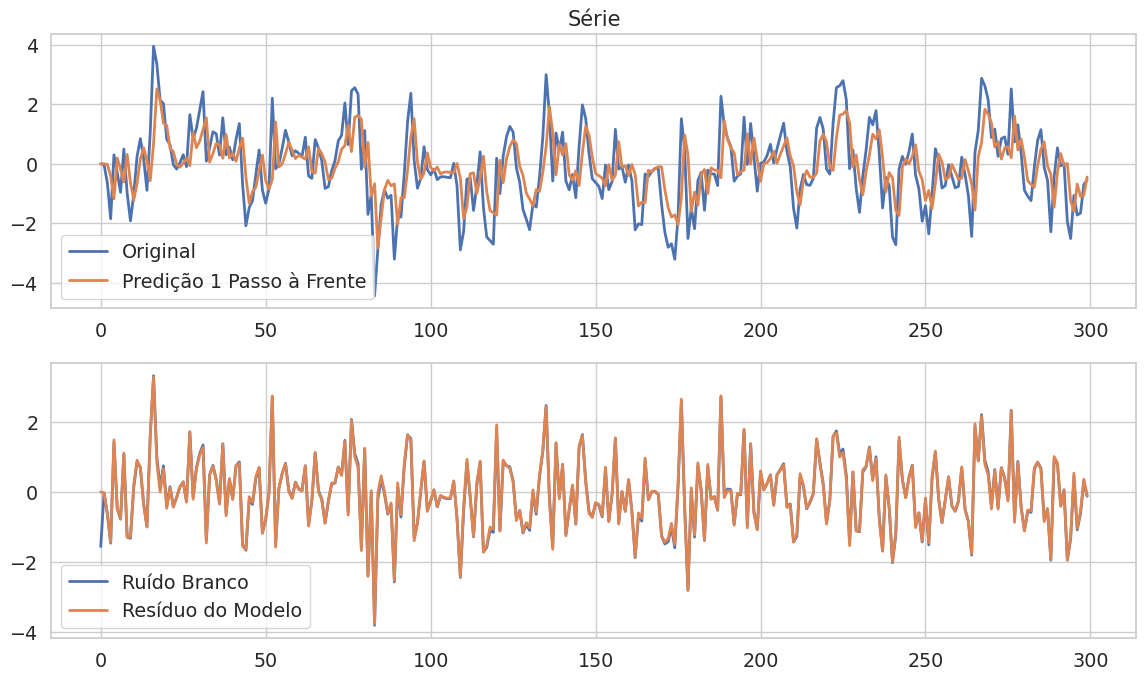

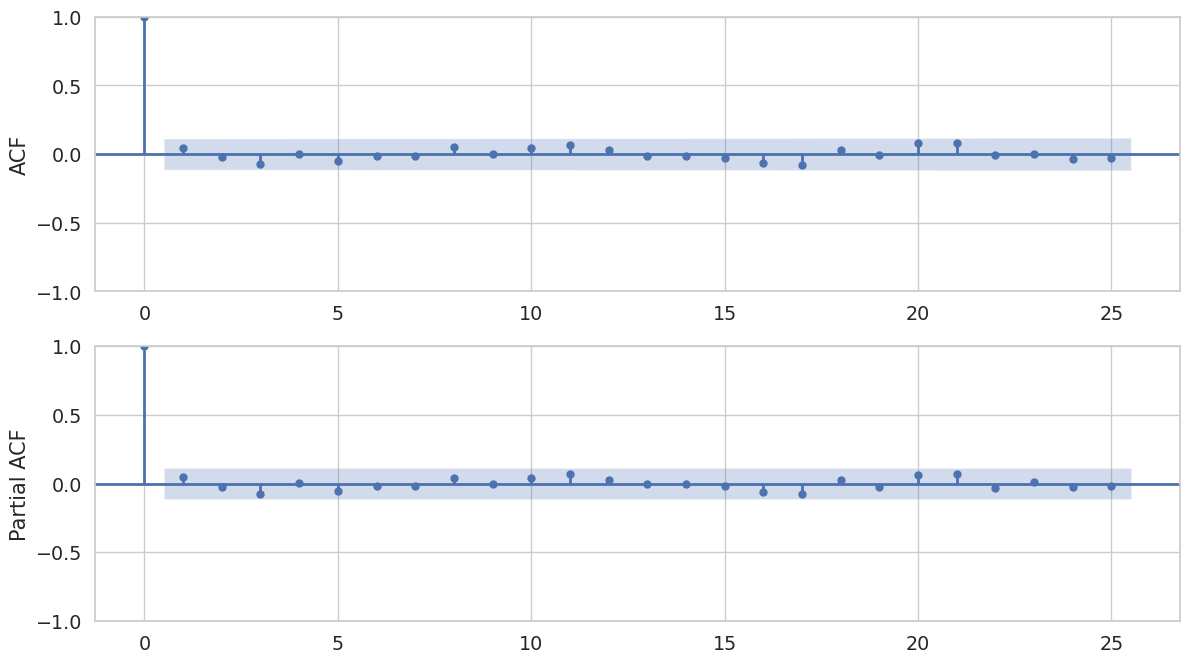

In [7]:
Y = y[1:]
X = np.hstack([y[:-1]])

W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)

y_pred = np.vstack([0, X.dot(W)])
r = y - y_pred

plot_osa(t, y, y_pred, e, r)
plot_corr(r)

print(f"""
Equação estimada         ~  y[k] = {W[0][0]:+.2f} y[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  {(r ** 2).mean():.4f}
AIC                      ~  {aic(r, 1):.4f}
BIC                      ~  {bic(r, 1):.4f}
""")

Processo ARIMA(1, 0, 1) ~ ARMA(1, 1) - Mínimos Quadrados Recursivos
---------------------------------------------------------------------

\begin{equation}
    y_k = 0.3 y_{k-1} + 0.5 \xi_{k-1} + \xi_k
\end{equation}

onde $\xi_k \sim N(0, 1)$

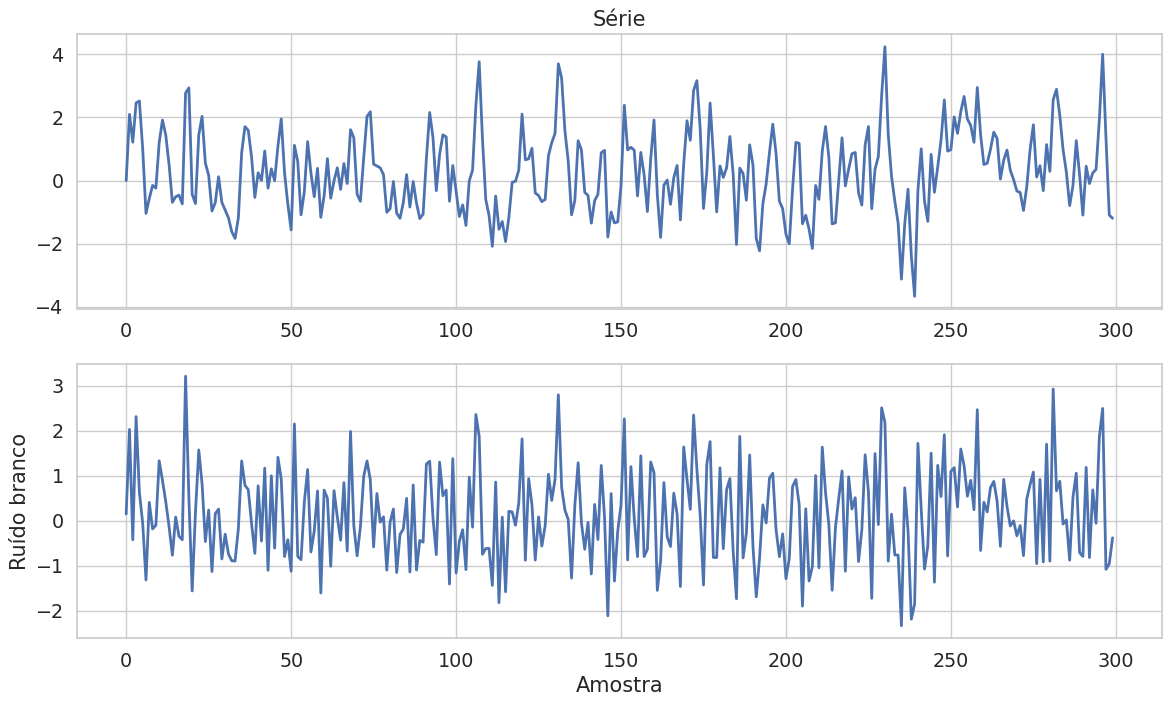

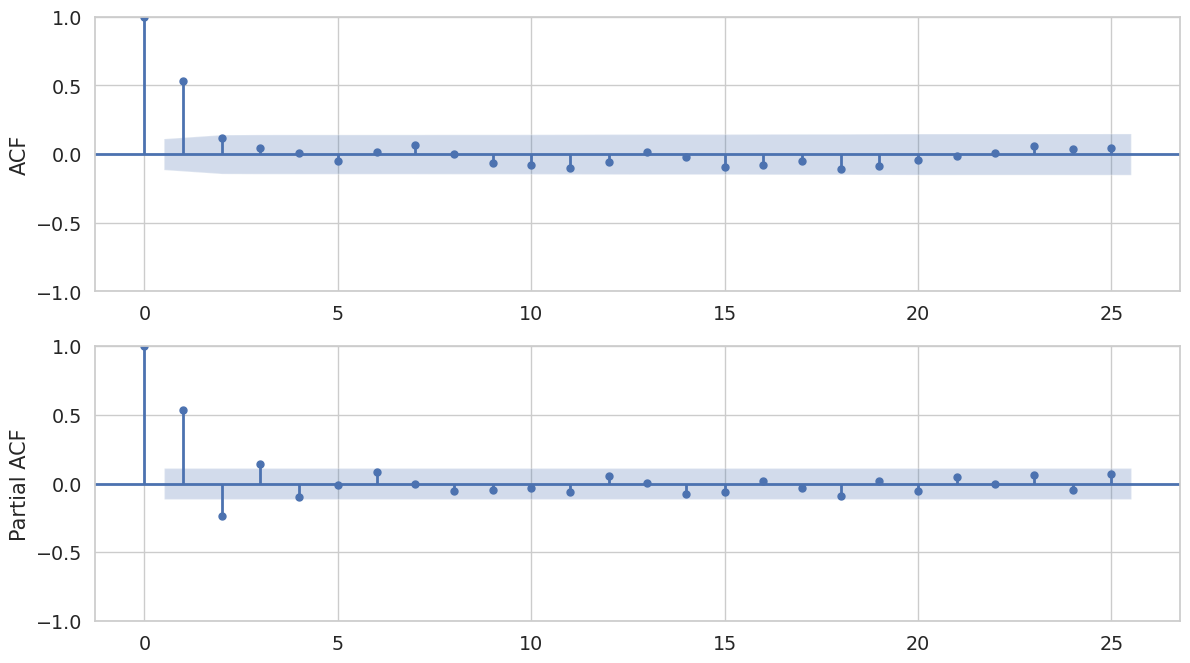

In [33]:
random.seed(120)
np.random.seed(120)

samples = 300

t = np.arange(samples)
y = np.zeros((samples, 1))
e = np.random.randn(samples, 1)

for k in range(1, samples):
    y[k] = 0.3 * y[k-1] + 0.5 * e[k-1] + e[k]

plot_ts(t, y, e)
plot_corr(y)

In [34]:
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd

def compare_models(y, orders):
    models = []
    for order in orders:
        model = ARIMA(y, order=order)
        resul = model.fit()
        models.append([order, resul.aic, resul.bic])
    df = pd.DataFrame(models, columns=["order", "aic", "bic"])
    return df.set_index("order").sort_values(by="aic")

models = compare_models(y, [
    (1, 0, 0),
    (1, 0, 1),
    (2, 0, 0),
    (0, 0, 1),
    (0, 0, 2),
])

models

,aic,bic
order,,
"(0, 0, 2)",880.086303,894.901433
"(1, 0, 1)",880.168230,894.983360
"(0, 0, 1)",883.868333,894.979680
"(2, 0, 0)",887.861892,902.677022
"(1, 0, 0)",903.426993,914.538340



Equação estimada         ~  y[k] = +0.56 y[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  1.1796
AIC                      ~  901.2356
BIC                      ~  908.6432



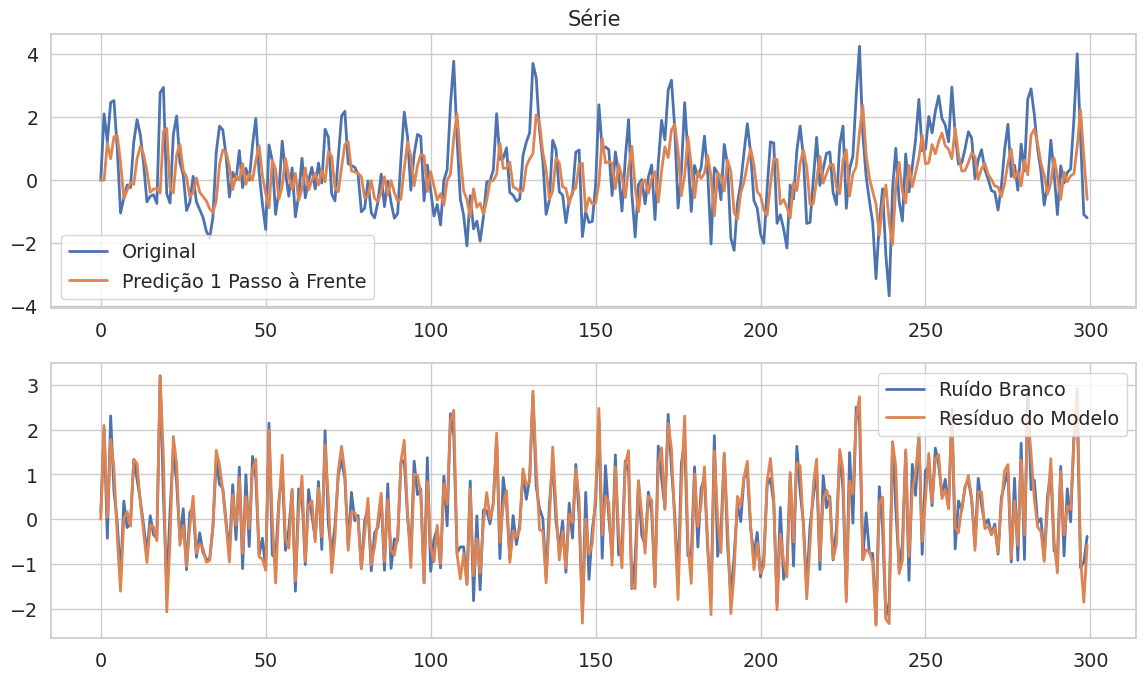

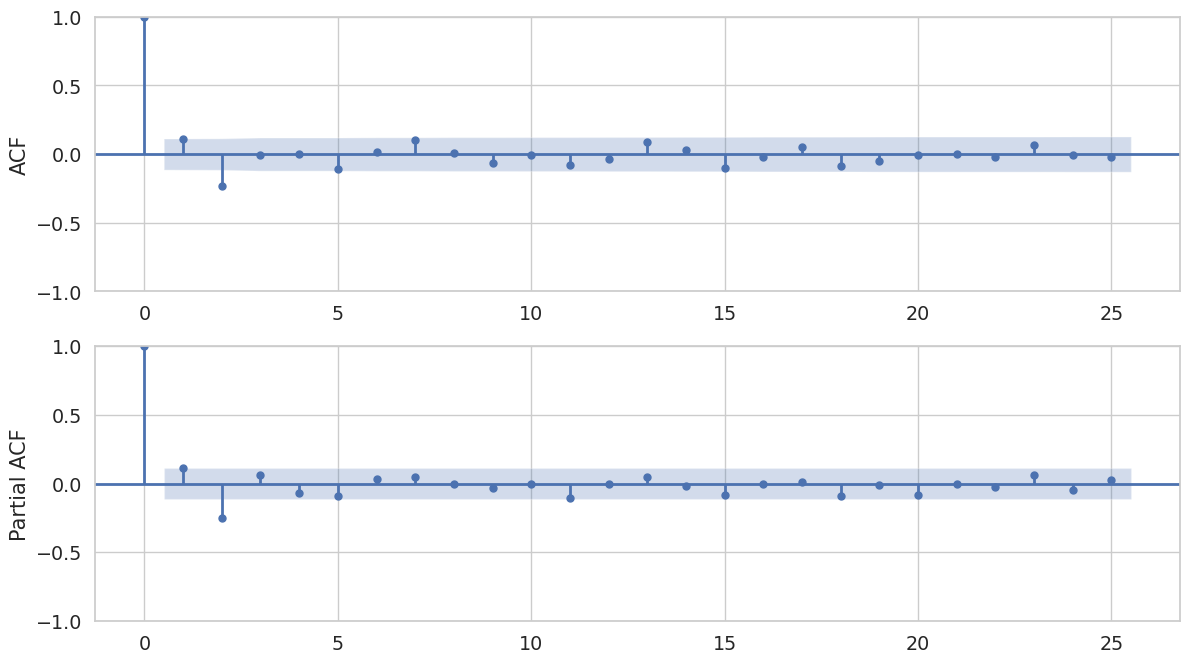

In [35]:
Y = y[1:]
X = np.hstack([y[:-1]])

W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)

y_pred = np.vstack([0, X.dot(W)])
r = y - y_pred

plot_osa(t, y, y_pred, e, r)
plot_corr(r)

print(f"""
Equação estimada         ~  y[k] = {W[0][0]:+.2f} y[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  {(r ** 2).mean():.4f}
AIC                      ~  {aic(r, 2):.4f}
BIC                      ~  {bic(r, 2):.4f}
""")


Equação estimada         ~  y[k] = +0.26 y[k-1]
                                   +0.47 e[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  1.0915
AIC                      ~  878.3154
BIC                      ~  889.4267



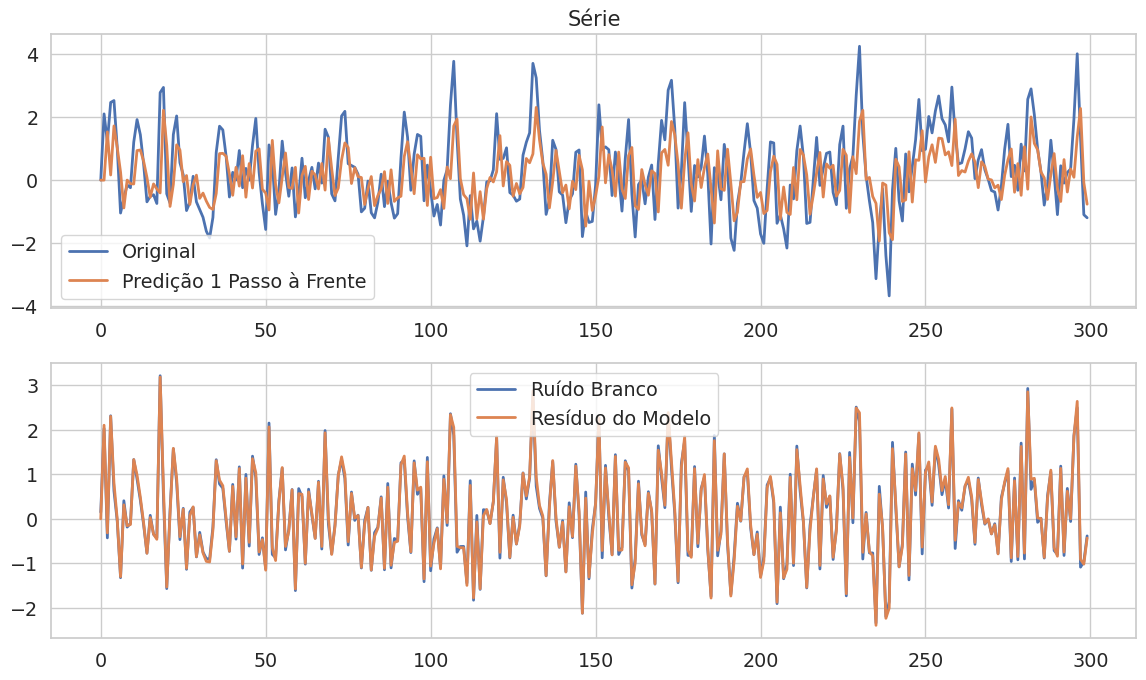

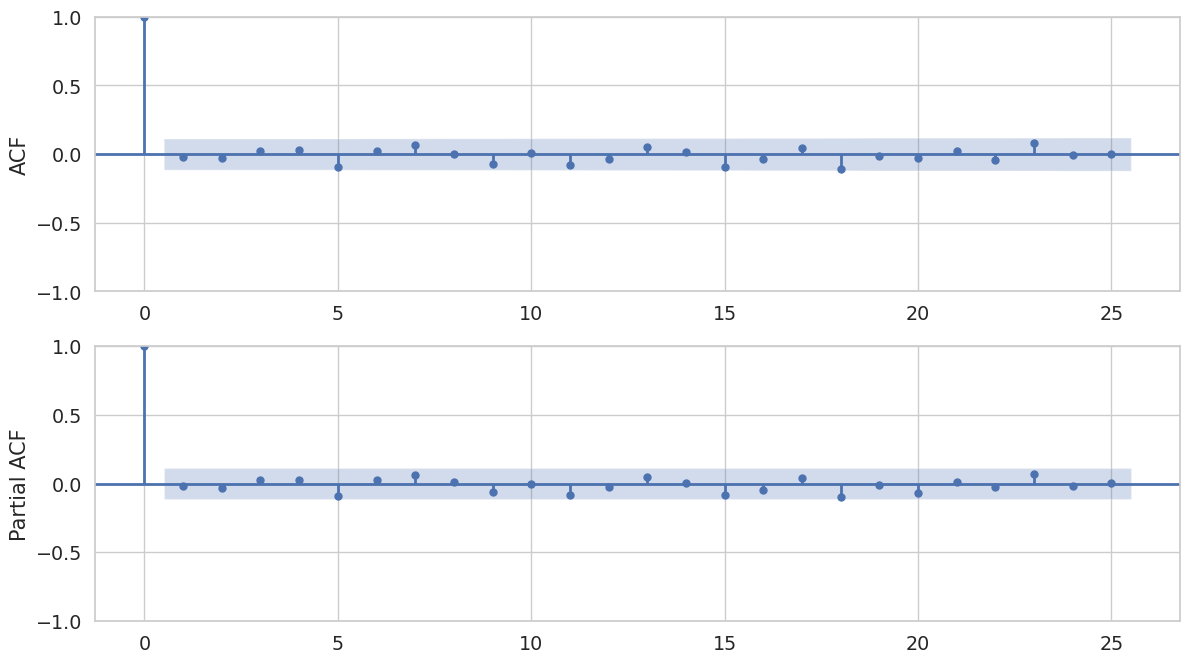

In [36]:
# Começamos assumindo que o resíduo é nulo
r = np.zeros_like(y)

# Inicializamos o vetor `target` (saída desejada)
Y = y[1:]

# Repetimos, 10 vezes, a estimativa dos parâmetros
for _ in range(10):
    X = np.hstack([y[:-1], r[:-1]])
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    y_pred = np.vstack([0, X.dot(W)])
    r = y - y_pred

plot_osa(t, y, y_pred, e, r)
plot_corr(r)

print(f"""
Equação estimada         ~  y[k] = {W[0][0]:+.2f} y[k-1]
                                   {W[1][0]:+.2f} e[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  {(r ** 2).mean():.4f}
AIC                      ~  {aic(r, 3):.4f}
BIC                      ~  {bic(r, 3):.4f}
""")

Processo ARIMA(1, 1, 1) - Mínimos Quadrados Recursivos
----------------------------------------------------------------------

\begin{equation}
    z_k = y_k - y_{k-1}
\end{equation}
\begin{equation}
    z_k = 0.6 z_{k-1} + 0.4 \xi_{k-1} + \xi_k
\end{equation}

onde $\xi_k \sim N(0, 1)$

Note que se substituir-mos a primeira equação na segunda, obtemos o processo:

\begin{equation}
    y_{k} - y_{k-1} = 0.6 (y_{k-1} - y_{k-2}) + 0.4 \xi_{k-1} + \xi_k
\end{equation}

\begin{equation}
    y_{k} = 1.6 y_{k-1} - 0.6 y_{k-2} + 0.4 \xi_{k-1} + \xi_k
\end{equation}

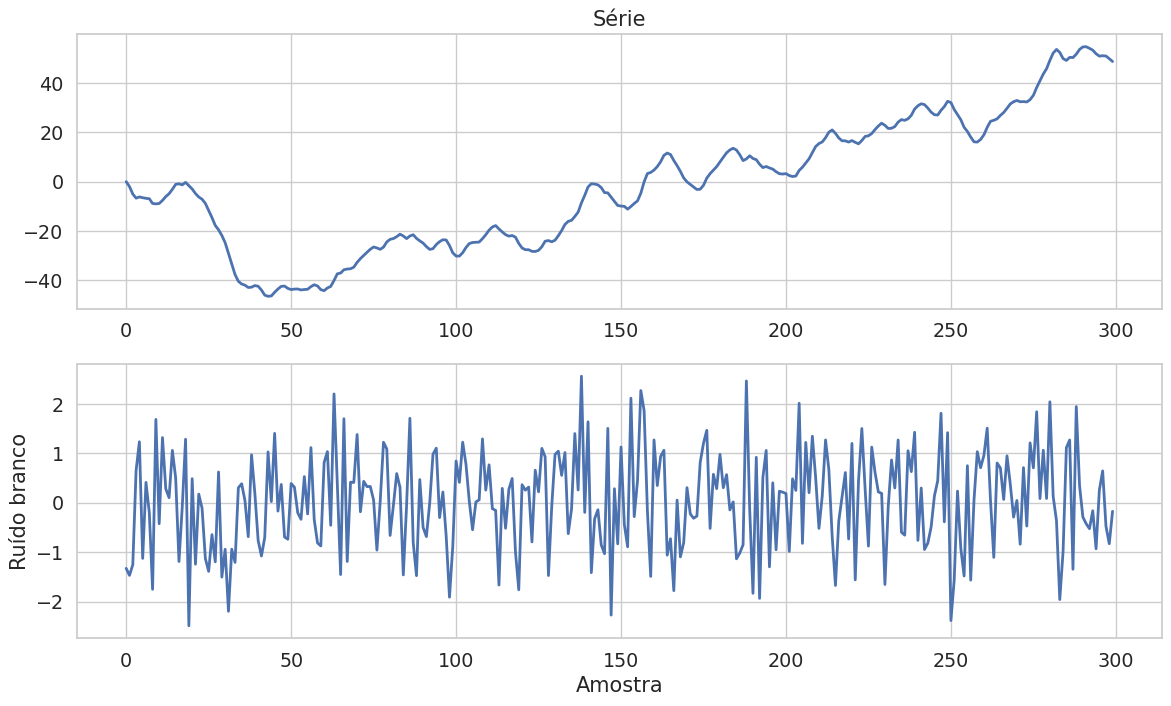

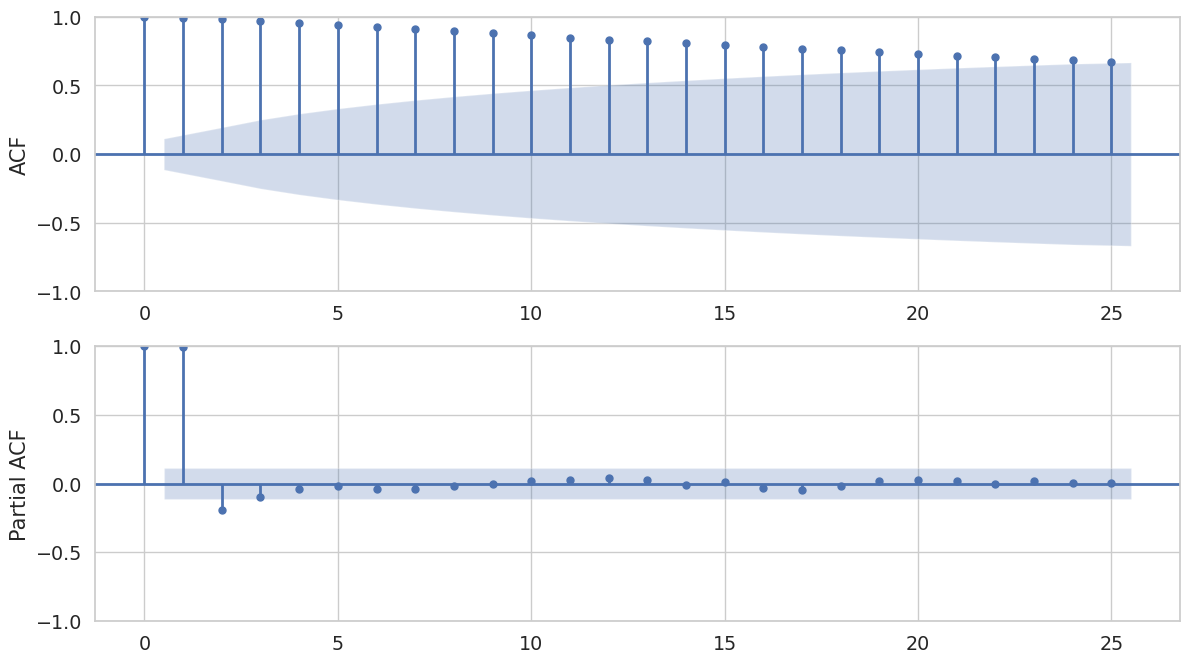

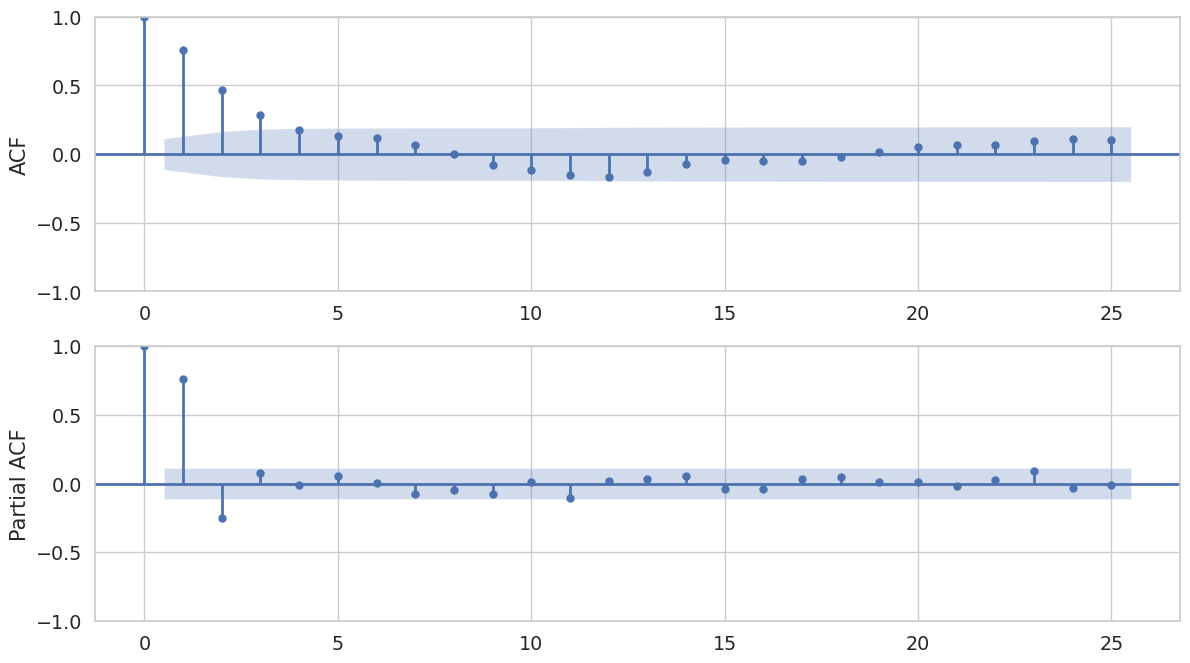

In [38]:
random.seed(220)
np.random.seed(220)

samples = 300

t = np.arange(samples)
y = np.zeros((samples, 1))
z = np.zeros((samples, 1))
e = np.random.randn(samples, 1)

for k in range(1, samples):
    z[k] = 0.6 * z[k-1] + 0.4 * e[k-1] + e[k]
    y[k] = y[k-1] + z[k]

plot_ts(t, y, e)
plot_corr(y)
plot_corr(z)


Equação estimada         ~  y[k] = +1.00 y[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  2.457960045406526
AIC                      ~  1119.6362
BIC                      ~  1123.3400



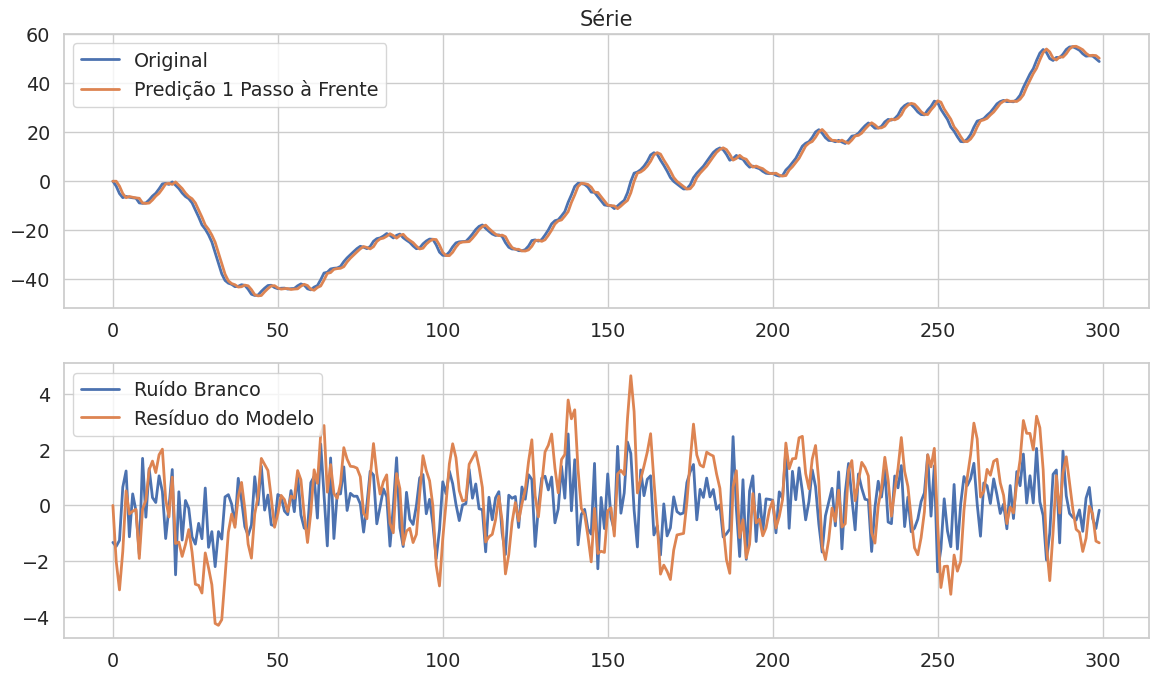

In [39]:
Y = y[1:]
X = np.hstack([y[:-1]])

W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)

y_pred = np.vstack([0, X.dot(W)])
r = y - y_pred

plot_osa(t, y, y_pred, e, r)

print(f"""
Equação estimada         ~  y[k] = {W[0][0]:+.2f} y[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  {(r ** 2).mean()}
AIC                      ~  {aic(r, 1):.4f}
BIC                      ~  {bic(r, 1):.4f}
""")


Equação estimada         ~  y[k] = +1.63 y[k-1] 
                                   -0.63 y[k-2]
                                   +0.34 e[k-1]
                                   +1.00 e[k]
Erro médio quadrático    ~  0.9592623340924327
AIC                      ~  844.3721
BIC                      ~  855.4834



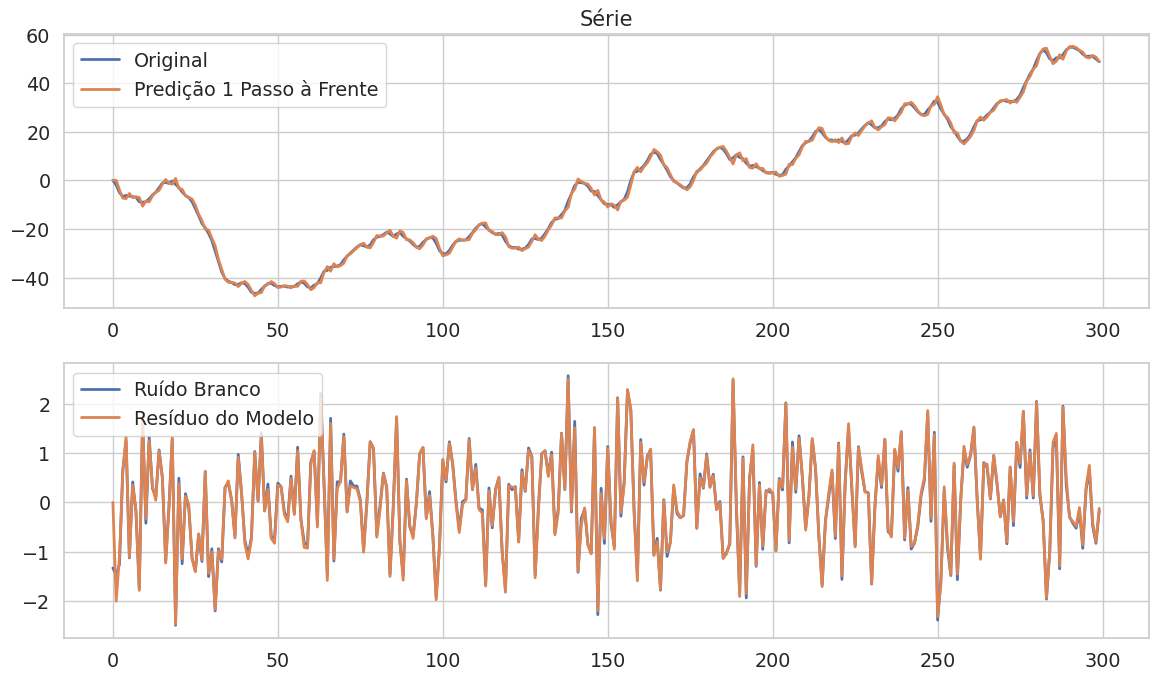

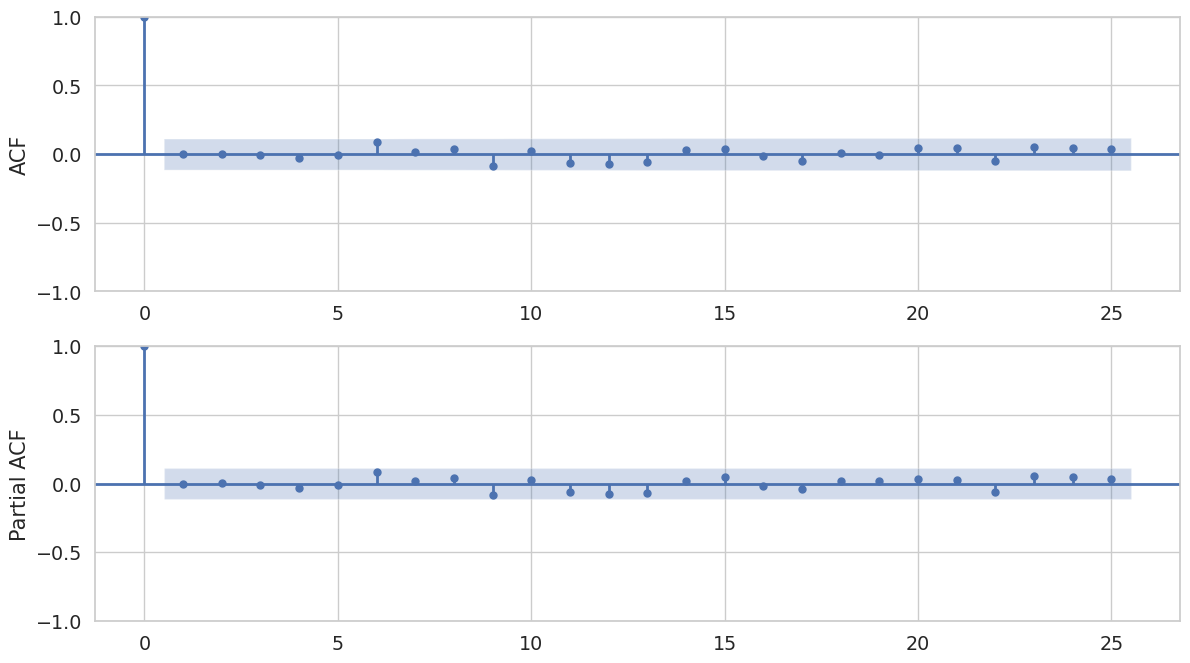

In [40]:
# Começamos assumindo que o resíduo é nulo
r = np.zeros_like(y)

# Inicializamos o vetor `target` (saída desejada)
Y = y[2:]

# Repetimos, 20 vezes, a estimativa dos parâmetros
for _ in range(20):
    X = np.hstack([y[1:-1], y[:-2], r[1:-1]])
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    y_pred = np.vstack([0, 0, X.dot(W)])
    r = y - y_pred

plot_osa(t, y, y_pred, e, r)
plot_corr(r)

print(f"""
Equação estimada         ~  y[k] = {W[0][0]:+.2f} y[k-1] 
                                   {W[1][0]:+.2f} y[k-2]
                                   {W[2][0]:+.2f} e[k-1]
                                   +1.00 e[k]
Erro médio quadrático    ~  {(r ** 2).mean()}
AIC                      ~  {aic(r, 3):.4f}
BIC                      ~  {bic(r, 3):.4f}
""")

Modelo ARMAX - Mínimos Quadrados Recursivos
-----------------------------------------------------------------------

\begin{equation}
    y_k = 0.5 y_{k-1} + 0.8 x_{k-1} + 0.4 \xi_{k-1} + \xi_k
\end{equation}

onde  
    $\xi_k \sim N(0, 1)$   
    $x_k \sim U(-1, 1)$  

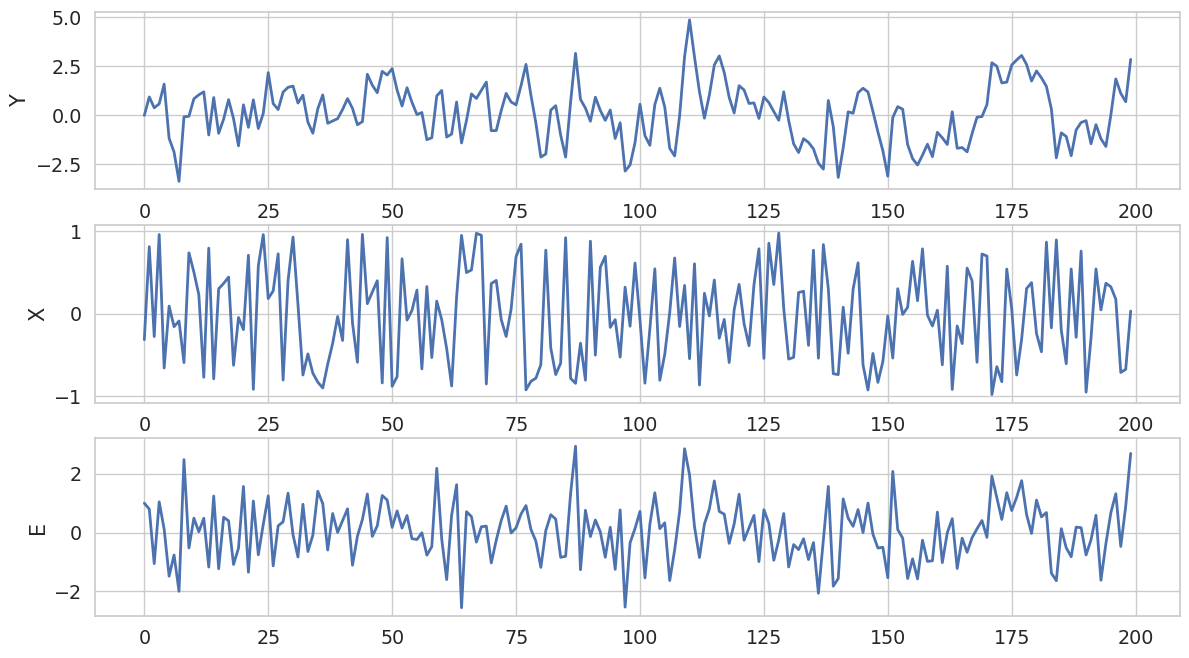

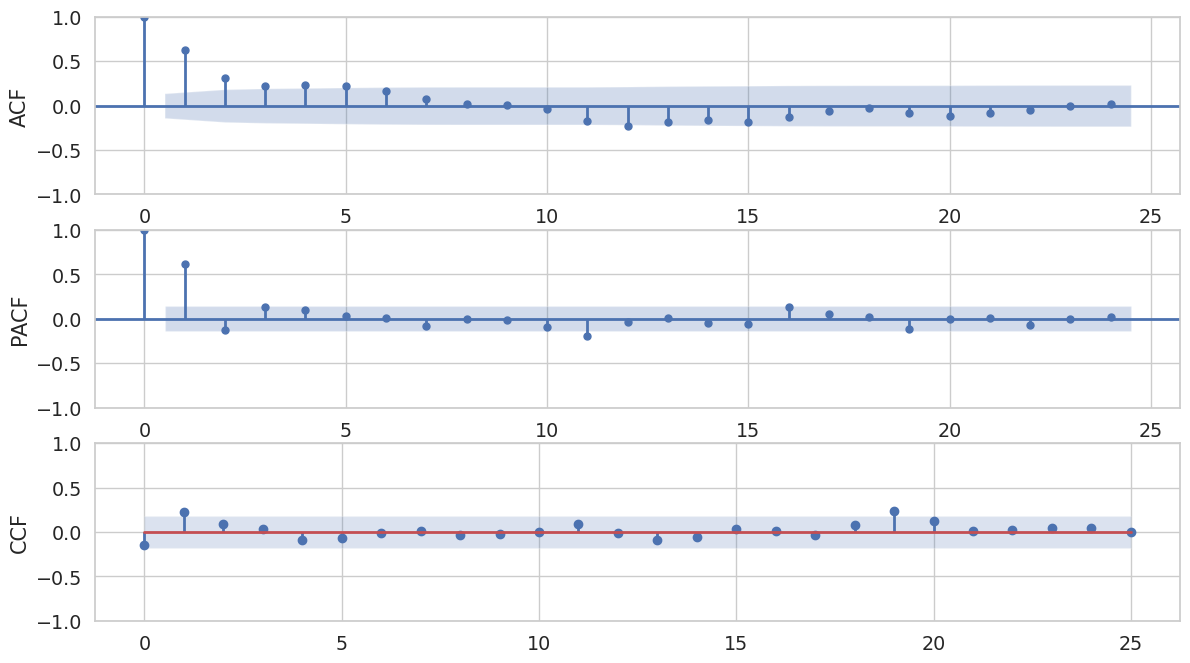

In [42]:
from statsmodels.tsa.stattools import ccf

random.seed(1442)
np.random.seed(1442)

samples = 200

t = np.arange(samples)
y = np.zeros((samples, 1))
x = np.random.rand(samples, 1) * 2 - 1 # U(0, 1) :: 2 * U(0, 1) -> U(0, 2) :: U(-1, 1)
e = np.random.randn(samples, 1)

for k in range(1, samples):
    y[k] = 0.5 * y[k-1] + 0.8 * x[k-1] + 0.4 * e[k-1] + e[k]

plt.subplot(311); plt.plot(t, y); plt.ylabel('Y')
plt.subplot(312); plt.plot(t, x); plt.ylabel('X')
plt.subplot(313); plt.plot(t, e); plt.ylabel('E')

def plot_cross(x, y, max_lags=26):
    cross_corr = ccf(x, y)[:max_lags]
    lags = np.arange(max_lags)
    conf = 2.578 / np.sqrt(len(x))
    
    plt.stem(lags, cross_corr); plt.ylabel("CCF");
    plt.fill_between(lags, conf, -conf, alpha=0.2)
    plt.ylim([-1, 1])

plt.figure()
ax = plt.subplot(311); plot_acf(y, ax=ax, title=""); plt.ylabel("ACF");
ax = plt.subplot(312); plot_pacf(y, ax=ax, title="", method="ywm"); plt.ylabel("PACF");
ax = plt.subplot(313); plot_cross(y, x)


Equação estimada         ~  y[k] = +0.49 y[k-1] 
                                   +0.25 e[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  1.2544146814894395
AIC                      ~  618.2127
BIC                      ~  628.1076



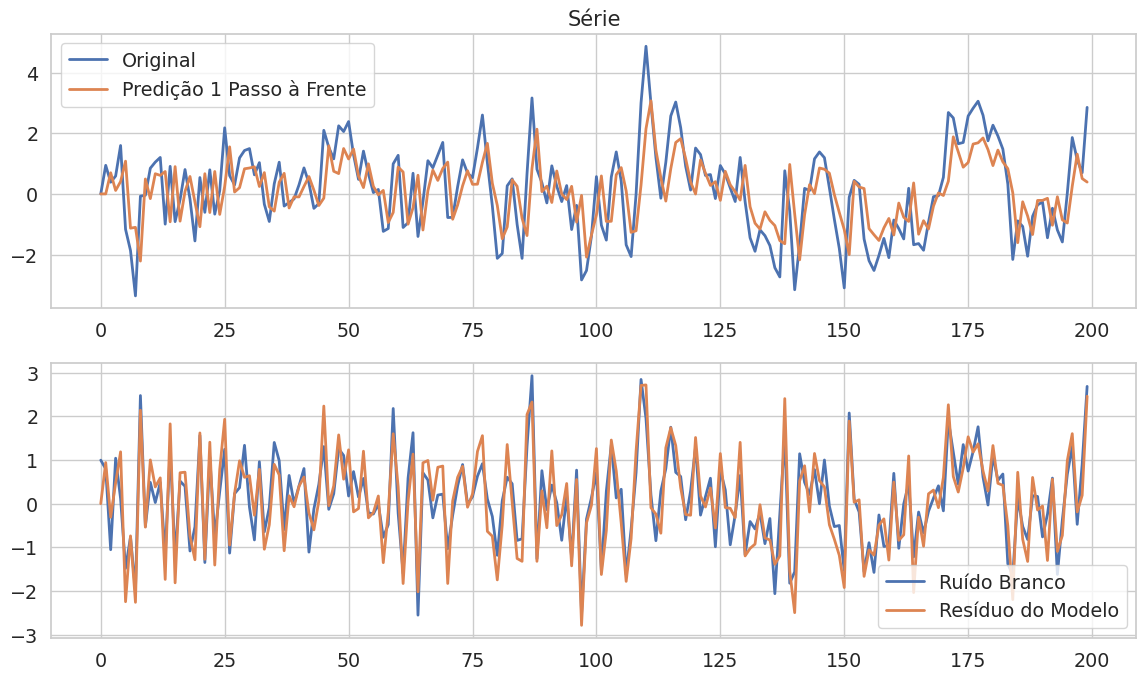

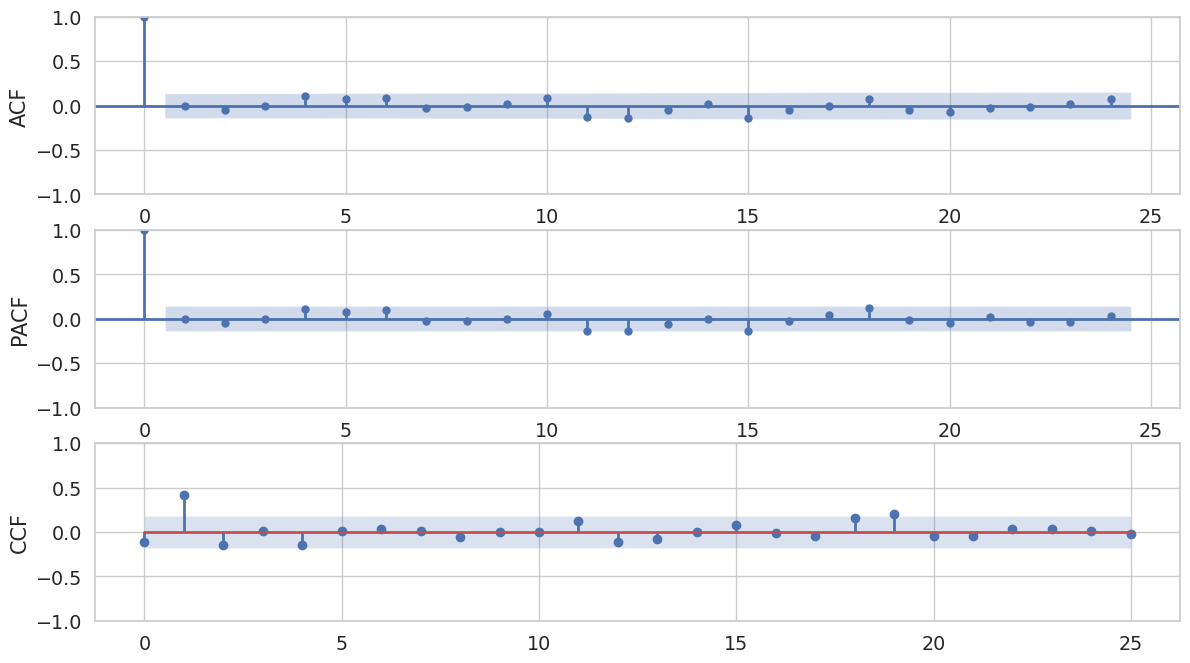

In [43]:
# Começamos assumindo que o resíduo é nulo
r = np.zeros_like(y)

# Inicializamos o vetor `target` (saída desejada)
Y = y[1:]

# Repetimos, 10 vezes, a estimativa dos parâmetros
for _ in range(20):
    X = np.hstack([y[:-1], r[:-1]])
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    y_pred = np.vstack([0, X.dot(W)])
    r = y - y_pred

plot_osa(t, y, y_pred, e, r)

plt.figure()
ax = plt.subplot(311); plot_acf(r, ax=ax, title=""); plt.ylabel("ACF");
ax = plt.subplot(312); plot_pacf(r, ax=ax, title="", method="ywm"); plt.ylabel("PACF");
ax = plt.subplot(313); plot_cross(r, x)

print(f"""
Equação estimada         ~  y[k] = {W[0][0]:+.2f} y[k-1] 
                                   {W[1][0]:+.2f} e[k-1] 
                                   +1.00 e[k]
Erro médio quadrático    ~  {(r ** 2).mean()}
AIC                      ~  {aic(r, 3):.4f}
BIC                      ~  {bic(r, 3):.4f}
""")


Equação estimada         ~  y[k] = +0.52 y[k-1] 
                                   +0.82 x[k-1]
                                   +0.37 e[k-1]
                                   +1.00 e[k]
Erro médio quadrático    ~  0.997829328502197
AIC                      ~  574.0065
BIC                      ~  587.1998



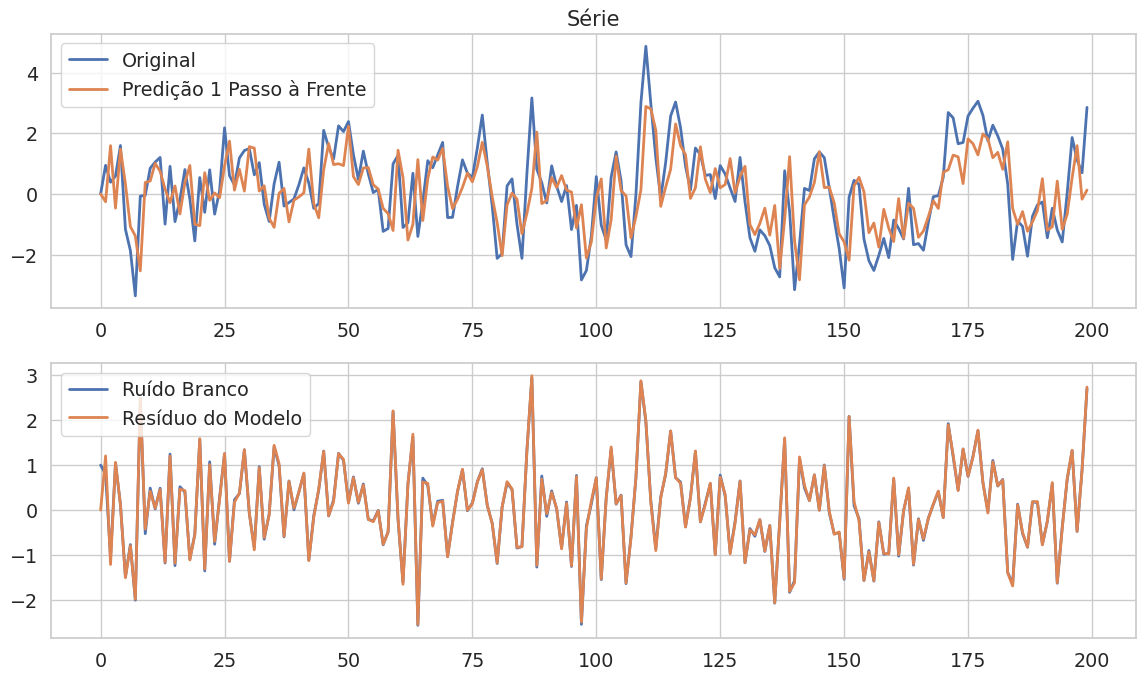

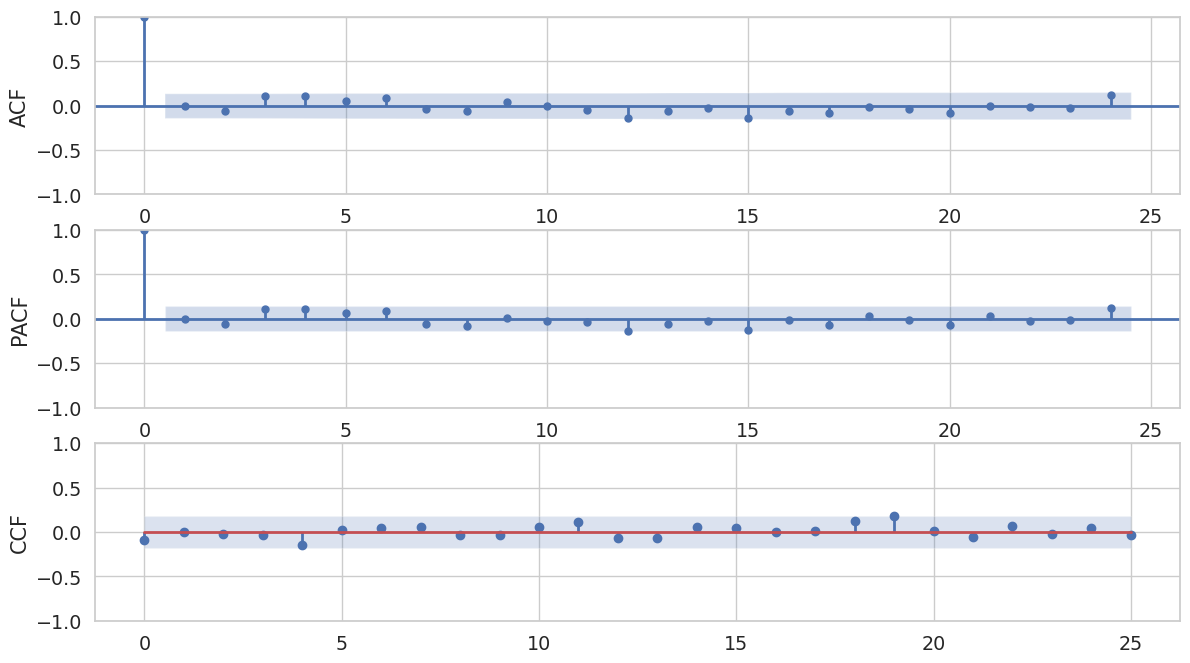

In [44]:
# Começamos assumindo que o resíduo é nulo
r = np.zeros_like(y)

# Inicializamos o vetor `target` (saída desejada)
Y = y[1:]

# Repetimos, 10 vezes, a estimativa dos parâmetros
for _ in range(50):
    X = np.hstack([y[:-1], x[:-1], r[:-1]])
    W = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(Y)
    y_pred = np.vstack([0, X.dot(W)])
    r = y - y_pred

plot_osa(t, y, y_pred, e, r)

plt.figure()
ax = plt.subplot(311); plot_acf(r, ax=ax, title=""); plt.ylabel("ACF");
ax = plt.subplot(312); plot_pacf(r, ax=ax, title="", method="ywm"); plt.ylabel("PACF");
ax = plt.subplot(313); plot_cross(r, x)

print(f"""
Equação estimada         ~  y[k] = {W[0][0]:+.2f} y[k-1] 
                                   {W[1][0]:+.2f} x[k-1]
                                   {W[2][0]:+.2f} e[k-1]
                                   +1.00 e[k]
Erro médio quadrático    ~  {(r ** 2).mean()}
AIC                      ~  {aic(r, 4):.4f}
BIC                      ~  {bic(r, 4):.4f}
""")

Exercício
========

Reconstrua as séries sintéticas da aula de hoje, modelando-as usando a biblioteca statsmodels.

Opcional: Particione os dados antes de uitilizar a biblioteca ARIMA, e verifique se o forecasting está
dentro dos limites de confiança dos modelos obtidos.

Dica: `from statsmodels.tsa.arima.model import ARIMA`